## Time Series Machine Learning

## New York Stock Exchange 

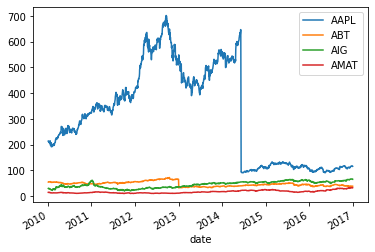

In [8]:
import pandas as pd
import matplotlib.pyplot as plt

# Read in the data
data = pd.read_csv('prices.csv', index_col=0)

# Convert the index of the DataFrame to datetime
data.index = pd.to_datetime(data.index)

data.reset_index(inplace=True)
data = data.pivot(index='date', columns='symbol', values='close')

# Loop through each column, plot its values over time
fig, ax = plt.subplots()
for column in data.columns[:4]:
    data[column].plot(ax=ax, label=column)
ax.legend()
plt.show()


## Classification and Feature Engineering on Time Series Data

### Dealing with messy raw data
- missing values ; one way to deal with this is by doing **interpolation**

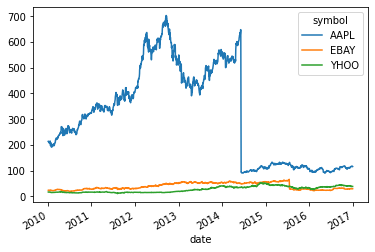

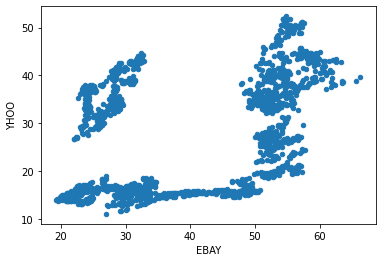

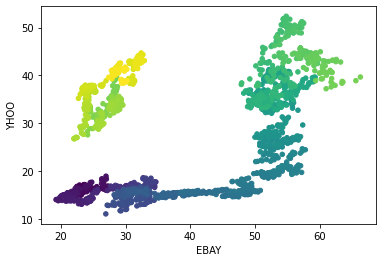

In [12]:
prices = data[["AAPL", "EBAY", "YHOO"]]
# Plot the raw values over time
prices.plot()
plt.show()

# Scatterplot with one company per axis
prices.plot.scatter('EBAY', 'YHOO')
plt.show()

# Scatterplot with color relating to time
prices.plot.scatter('EBAY', 'YHOO', c=prices.index, 
                    cmap=plt.cm.viridis, colorbar=False)
plt.show()

[  -0.55495235   -0.9912733  -322.41700994]
-3308.668763845217


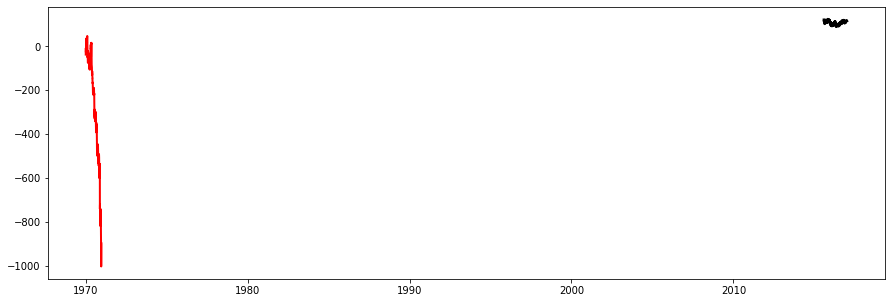

In [14]:


from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score

# Use stock symbols to extract training data
X = data[['EBAY','NVDA', 'YHOO']]
y = data[['AAPL']]

# Fit and score the model with cross-validation
scores = cross_val_score(Ridge(), X, y, cv=3)
print(scores)

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

# Split our data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.8, shuffle=False, random_state=1)

# Fit our model and generate predictions
model = Ridge()
model.fit(X_train, y_train)
predictions = model.predict(X_test)
score = r2_score(y_test, predictions)
print(score)

# Visualize our predictions along with the "true" values, and print the score
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(y_test, color='k', lw=3)
ax.plot(predictions, color='r', lw=2)
plt.show()

# Visualize the dataset
#prices.plot(legend=False)
#plt.tight_layout()
#plt.show()

### Outliers and Missing Values

In [ ]:
# Count the missing values of each time series
missing_values = prices.isnull().sum()
print(missing_values)

# Create a function we'll use to interpolate and plot
def interpolate_and_plot(prices, interpolation):

    # Create a boolean mask for missing values
    missing_values = prices.isna()

    # Interpolate the missing values
    prices_interp = prices.interpolate(interpolation)

    # Plot the results, highlighting the interpolated values in black
    fig, ax = plt.subplots(figsize=(10, 5))
    prices_interp.plot(color='k', alpha=.6, ax=ax, legend=False)
    
    # Now plot the interpolated values on top in red
    prices_interp[missing_values].plot(ax=ax, color='r', lw=3, legend=False)
    plt.show()

# Interpolate using the latest non-missing value
interpolation_type = 'linear'
interpolate_and_plot(prices, interpolation_type)

interpolation_type = 'quadratic'
interpolate_and_plot(prices, interpolation_type)

# Your custom function #data standardisation
def percent_change(series):
    # Collect all *but* the last value of this window, then the final value
    previous_values = series[:-1]
    last_value = series[-1]

    # Calculate the % difference between the last value and the mean of earlier values
    percent_change = (last_value - np.mean(previous_values)) / np.mean(previous_values)
    return percent_change

# Apply your custom function and plot
prices_perc = prices.rolling(20).apply(percent_change)
prices_perc.loc["2014":"2015"].plot()
plt.show()

#handling outliers
def replace_outliers(series):
    # Calculate the absolute difference of each timepoint from the series mean
    absolute_differences_from_mean = np.abs(series - np.mean(series))
    
    # Calculate a mask for the differences that are > 3 standard deviations from zero
    this_mask = absolute_differences_from_mean > (np.std(series) * 3)
    
    # Replace these values with the median accross the data
    series[this_mask] = np.nanmedian(series)
    return series

# Apply your preprocessing function to the timeseries and plot the results
prices_perc = prices_perc.apply(replace_outliers)
prices_perc.loc["2014":"2015"].plot()
plt.show()

## Time Series Feature Engineering 

In [ ]:
# Define a rolling window with Pandas, excluding the right-most datapoint of the window
prices_perc_rolling = prices_perc.rolling(20, min_periods=5, closed='right')

# Define the features you'll calculate for each window
features_to_calculate = [np.min, np.max, np.mean, np.std]

# Calculate these features for your rolling window object
features = prices_perc_rolling.aggregate(features_to_calculate)

# Plot the results
ax = features.loc[:"2011-01"].plot()
prices_perc.loc[:"2011-01"].plot(ax=ax, color='k', alpha=.2, lw=3)
ax.legend(loc=(1.01, .6))
plt.show()

# Import partial from functools
from functools import partial
percentiles = [1, 10, 25, 50, 75, 90, 99]

# Use a list comprehension to create a partial function for each quantile
percentile_functions = [partial(np.percentile, q=percentile) for percentile in percentiles]

# Calculate each of these quantiles on the data using a rolling window
prices_perc_rolling = prices_perc.rolling(20, min_periods=5, closed='right')
features_percentiles = prices_perc_rolling.aggregrate(percentile_functions)

# Plot a subset of the result
ax = features_percentiles.loc[:"2011-01"].plot(cmap=plt.cm.viridis)
ax.legend(percentiles, loc=(1.01, .5))
plt.show()

# Extract date features from the data, add them as columns
prices_perc['day_of_week'] = prices_perc.index.dayofweek
prices_perc['week_of_year'] = prices_perc.index.weekofyear
prices_perc['month_of_year'] = prices_perc.index.month

# Print prices_perc
print(prices_perc)

## Time lagged features

In [ ]:
# These are the "time lags"
shifts = np.arange(1, 11).astype(int)

# Use a dictionary comprehension to create name: value pairs, one pair per shift
shifted_data = {"lag_{}_day".format(day_shift): prices_perc.shift(day_shift) for day_shift in shifts}

# Convert into a DataFrame for subsequent use
prices_perc_shifted = pd.DataFrame(shifted_data)

# Plot the first 100 samples of each
ax = prices_perc_shifted.iloc[:100].plot(cmap=plt.cm.viridis)
prices_perc.iloc[:100].plot(color='r', lw=2)
ax.legend(loc='best')
plt.show()

#You are using previous values of a timeseries to predict current values of the same timeseries (thus, it is auto-regressive)
# Replace missing values with the median for each column
X = prices_perc_shifted.fillna(np.nanmedian(prices_perc_shifted))
y = prices_perc.fillna(np.nanmedian(prices_perc))

# Fit the model
model = Ridge()
model.fit(X, y)

def visualize_coefficients(coefs, names, ax):
    # Make a bar plot for the coefficients, including their names on the x-axis
    ax.bar(names,coefs)
    ax.set(xlabel='Coefficient name', ylabel='Coefficient value')
    
    # Set formatting so it looks nice
    plt.setp(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
    return ax

# Visualize the output data up to "2011-01"
fig, axs = plt.subplots(2, 1, figsize=(10, 5))
y.loc[:'2011-01'].plot(ax=axs[0])

# Run the function to visualize model's coefficients
visualize_coefficients(model.coef_, prices_perc_shifted.columns, ax=axs[1])
plt.show()

### Time-series Cross Validation


In [ ]:
# Import ShuffleSplit and create the cross-validation object
from sklearn.model_selection import ShuffleSplit
cv = ShuffleSplit(n_splits=10, random_state=1)

# Iterate through CV splits
results = []
for tr, tt in cv.split(X, y):
    # Fit the model on training data
    model.fit(X[tr], y[tr])

    # Generate predictions on the test data, score the predictions, and collect
    prediction = model.predict(X[tt])
    score = r2_score(y[tt], prediction)
    results.append((prediction, score, tt))
    
# Custom function to quickly visualize predictions
visualize_predictions(results)

# Create KFold cross-validation object #correct validation one
from sklearn.model_selection import KFold
cv = KFold(n_splits=10, shuffle=False, random_state=1)

# Iterate through CV splits
results = []
for tr, tt in cv.split(X, y):
    # Fit the model on training data
    model.fit(X[tr], y[tr])
    
    # Generate predictions on the test data and collect
    prediction = model.predict(X[tt])
    results.append((prediction, tt))
    
# Custom function to quickly visualize predictions
visualize_predictions(results)

# Import TimeSeriesSplit
from sklearn.model_selection import TimeSeriesSplit

# Create time-series cross-validation object
cv = TimeSeriesSplit(10)

# Iterate through CV splits
fig, ax = plt.subplots()
for ii, (tr, tt) in enumerate(cv.split(X, y)):
    # Plot the training data on each iteration, to see the behavior of the CV
    ax.plot(tr, ii + y[tr])

ax.set(title='Training data on each CV iteration', ylabel='CV iteration')
plt.show()

# Plot the results
fig, ax = plt.subplots()
scores_lo.plot(ax=ax, label="Lower confidence interval")
scores_hi.plot(ax=ax, label="Upper confidence interval")
ax.legend()
plt.show()
    

In [ ]:
from sklearn.utils import resample

def bootstrap_interval(data, percentiles=(2.5, 97.5), n_boots=100):
    """Bootstrap a confidence interval for the mean of columns of a 2-D dataset."""
    # Create our empty array to fill the results
    bootstrap_means = np.zeros([n_boots, data.shape[-1]])
    for ii in range(n_boots):
        # Generate random indices for our data *with* replacement, then take the sample mean
        random_sample = resample(data)
        bootstrap_means[ii] = random_sample.mean(axis=0)
        
    # Compute the percentiles of choice for the bootstrapped means
    percentiles = np.percentile(bootstrap_means, percentiles, axis=0)
    return percentiles

# Iterate through CV splits
n_splits = 100
cv = TimeSeriesSplit(n_splits=n_splits)

# Create empty array to collect coefficients
coefficients = np.zeros([n_splits, X.shape[1]])

for ii, (tr, tt) in enumerate(cv.split(X, y)):
    # Fit the model on training data and collect the coefficients
    model.fit(X[tr], y[tr])
    coefficients[ii] = model.coef_

# Calculate a confidence interval around each coefficient
bootstrapped_interval = bootstrap_interval(coefficients)

# Plot it
fig, ax = plt.subplots()
ax.scatter(feature_names, bootstrapped_interval[0], marker='_', lw=3)
ax.scatter(feature_names, bootstrapped_interval[1], marker='_', lw=3)
ax.set(title='95% confidence interval for model coefficients')
plt.setp(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.show()

from sklearn.model_selection import cross_val_score

# Generate scores for each split to see how the model performs over time
scores = cross_val_score(model, X, y, cv=cv, scoring=my_pearsonr)

# Convert to a Pandas Series object
scores_series = pd.Series(scores, index=times_scores, name='score')

# Bootstrap a rolling confidence interval for the mean score
scores_lo = scores_series.rolling(20).aggregate(partial(bootstrap_interval, percentiles=2.5))
scores_hi = scores_series.rolling(20).aggregate(partial(bootstrap_interval, percentiles=97.5))